# Investigation of High-Level MAC Game Rate Regions

This script investigates whether the quantum finger printing advantage translates to a true improvement in mutual information $I(Z;X_1,X_2)$.
This means that MAC behavior has columns that are mixtures of deterministic mappings and uniform noise mappings.
This is differs from the nonlocal MAC game with answers $I(Z;X_1,X_2,Y_1,Y_2)$.
The key difference is that the inputs $Y_1$ and $Y_2$ are not independent, furthermore, the deterministic columns and noise columns are distinct and not mixed 

In [44]:
from qnet_context import QNetOptimizer as QNopt
from mac_context import *
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [45]:
ea_prep_node = [
    QNopt.PrepareNode(1, [0,1], QNopt.ghz_state, 0)
]
cl_prep_node = [
    QNopt.PrepareNode(1, [0,1], lambda settings, wires: None, 0)
]
ry_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(3, 2, [1], QNopt.local_RY, 1)
]

ea_ansatz = QNopt.NetworkAnsatz(ea_prep_node, ry_meas_nodes)
cl_ansatz = QNopt.NetworkAnsatz(cl_prep_node, ry_meas_nodes)

# uniform prior distribution
uniform3 = np.ones(3)/3

In [46]:
def big_mac_game_behavior_fn(ansatz):
    """Constructs and ansatz-specific behavior function.
    
    The the function is called as `behavior(ansatz_settings)`.
    
    The constructed behavior has form P(z|x1,x2)..
    """
        
    fp_behavior = QNopt.behavior_fn(ansatz, post_map=np.array([[1,0,0,1],[0,1,1,0]]))
    
    def behavior_fn(settings):
        
        raw_behavior = fp_behavior(settings)    
               
        P_win = []
        for x in range(3):
            for y in range(3):    
                row_id = 0 if x == y else 1
                P_win.append(raw_behavior[row_id, 3*x + y])         
                
        behavior = np.diag(P_win)
                
        for i in range(len(P_win)):
            P_lose = 1 - P_win[i]
            behavior[:,i] += P_lose * np.ones(9)/9
                                    
        return behavior       
    
    return behavior_fn

In [47]:
def mutual_info_finger_printing_cost_fn(ansatz, priors):
    
    probs_qnode = QNopt.joint_probs_qnode(ansatz)
    P_xy = np.kron(priors[0],priors[1])
    H_X = QNopt.shannon_entropy(P_xy)
    
    def cost_fn(ansatz_settings):
        # optimize winning probability     
        P_Z_list = []
        for x in range(3):
            for y in range(3):
                
                settings = ansatz.qnode_settings(ansatz_settings, [0], [x, y]) # prep node is static
                probs_xy = probs_qnode(settings)
                                
                prior = priors[0][x] * priors[1][y]   
                win_ids = [0,3] if x == y else [1,2]
                
                P_win = np.sum(probs_xy[win_ids])
                
                P_Z_xy = np.ones(9)/9*(1-P_win) + np.array([P_win if 3*x + y == i else 0 for i in range(9)])
                             
                P_Z_list.append(P_Z_xy)
        
        # postprocess winning probablity into mutual information
        P_zxy = np.array(P_Z_list).T * P_xy
                
        H_ZXY = QNopt.shannon_entropy(P_zxy.T.reshape(81))
        
        P_Z = np.sum(P_zxy, axis=1)
                
        H_Z = QNopt.shannon_entropy(P_Z)
                
        mutual_info = H_Z + H_X - H_ZXY
                        
        return -(mutual_info)
    
    return cost_fn

In [48]:
def scan_fp_rate_region(ansatz, prior_x1_samples, prior_x2_samples, **opt_kwargs):
    
    rate_tuples = []
    opt_dicts = []
    priors_list = []
    for prior_x1 in prior_x1_samples:
        for prior_x2 in prior_x2_samples:
            print("prior_x1  = ", prior_x1)
            print("prior_x2 = ", prior_x2)
            
            cost = mutual_info_finger_printing_cost_fn(ansatz, [prior_x1, prior_x2])

            opt_dict = QNopt.gradient_descent(
                cost,
                ansatz.rand_scenario_settings(),
                **opt_kwargs
            )
            
            mac_behavior = big_mac_game_behavior_fn(ansatz)
                   
            P_mac = mac_behavior(opt_dict["opt_settings"])
            rate_tuple = bisender_mac_mutual_info(P_mac, prior_x1, prior_x2)
            print(rate_tuple)
        
            opt_dicts.append(opt_dict)
            rate_tuples.append(rate_tuple)
            priors_list.append([prior_x1, prior_x2])
                  
    return rate_tuples, opt_dicts, priors_list

In [49]:
cl_rate_tuples = []
cl_opt_dicts = []
cl_priors_list = []

In [63]:
scan_range3 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(3)
], axis=0)

cl_rate_tuples3, cl_opt_dicts3, cl_priors_list3 = scan_fp_rate_region(
    cl_ansatz,
    scan_range3,
    scan_range3,
    sample_width = 5,
    num_steps = 60,
    step_size = 0.5
)

cl_rate_tuples.extend(cl_rate_tuples3)
cl_opt_dicts.extend(cl_opt_dicts3)
cl_priors_list.extend(cl_priors_list3)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.0
elapsed time :  0.04033708572387695
iteration :  5 , score :  0.0
elapsed time :  0.0371088981628418
iteration :  10 , score :  0.0
elapsed time :  0.0321040153503418
iteration :  15 , score :  0.0
elapsed time :  0.03240394592285156
iteration :  20 , score :  0.0
elapsed time :  0.03239583969116211
iteration :  25 , score :  0.0
elapsed time :  0.03160691261291504
iteration :  30 , score :  0.0
elapsed time :  0.03229212760925293
iteration :  35 , score :  0.0
elapsed time :  0.03434491157531738
iteration :  40 , score :  0.0
elapsed time :  0.040075063705444336
iteration :  45 , score :  0.0
elapsed time :  0.039630889892578125
iteration :  50 , score :  0.0
elapsed time :  0.13997912406921387
iteration :  55 , score :  0.0
elapsed time :  0.03339791297912598
(0.0, 0.0, 0.0)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , score :  0.18762106920146948
elapsed time :  0.036412954330444

elapsed time :  0.14975810050964355
iteration :  45 , score :  1.8390118117536352
elapsed time :  0.045120954513549805
iteration :  50 , score :  1.8390118024849516
elapsed time :  0.05551719665527344
iteration :  55 , score :  1.8390118019150328
elapsed time :  0.04441404342651367
(1.2688645835052337, 0.7767844820242327, 1.8390118018799897)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0.333 0.333 0.333]
iteration :  0 , score :  0.8205297462631389
elapsed time :  0.06206011772155762
iteration :  5 , score :  1.0427888338305733
elapsed time :  0.061120033264160156
iteration :  10 , score :  1.3784795812392368
elapsed time :  0.060945987701416016
iteration :  15 , score :  1.651941526462652
elapsed time :  0.06066608428955078
iteration :  20 , score :  1.8710574001158875
elapsed time :  0.16442608833312988
iteration :  25 , score :  1.9193884988668355
elapsed time :  0.04874897003173828
iteration :  30 , score :  1.9195101037821454
elapsed time :  0.04805898666381836
iteration :  35 , 

In [60]:
cl_rate_tuples__max, cl_opt_dicts_max, cl_priors_list_max = scan_fp_rate_region(
    cl_ansatz,
    [np.array([0.25,0.25,0.5])],
    [np.array([0.25,0.25,0.5])],
    sample_width = 5,
    num_steps = 60,
    step_size = 0.5
)

cl_rate_tuples.extend(cl_rate_tuples_max)
cl_opt_dicts.extend(cl_opt_dicts_max)
cl_priors_list.extend(cl_priors_list_max)

prior_x1  =  [0.25 0.25 0.5 ]
prior_x2 =  [0.25 0.25 0.5 ]
iteration :  0 , score :  1.1131175304479388
elapsed time :  0.16158509254455566
iteration :  5 , score :  1.5795461637190806
elapsed time :  0.0504150390625
iteration :  10 , score :  1.9162566506127794
elapsed time :  0.0503387451171875
iteration :  15 , score :  2.076975743611766
elapsed time :  0.04879283905029297
iteration :  20 , score :  2.2684840382665357
elapsed time :  0.04785895347595215
iteration :  25 , score :  2.409819408188011
elapsed time :  0.05001997947692871
iteration :  30 , score :  2.431281372585228
elapsed time :  0.04629874229431152
iteration :  35 , score :  2.431332714608474
elapsed time :  0.04775071144104004
iteration :  40 , score :  2.431303657010513
elapsed time :  0.04852914810180664
iteration :  45 , score :  2.431292188860803
elapsed time :  0.04693293571472168
iteration :  50 , score :  2.4312889382674996
elapsed time :  0.04731011390686035
iteration :  55 , score :  2.4312881835247078
elapse

In [64]:
scan_range4 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(4)
], axis=0)

cl_rate_tuples4, cl_opt_dicts4, cl_priors_list4 = scan_fp_rate_region(
    cl_ansatz,
    scan_range4,
    scan_range4,
    sample_width = 5,
    num_steps = 60,
    step_size = 0.5
)

cl_rate_tuples.extend(cl_rate_tuples4)
cl_opt_dicts.extend(cl_opt_dicts4)
cl_priors_list.extend(cl_priors_list4)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.0
elapsed time :  0.04182791709899902
iteration :  5 , score :  0.0
elapsed time :  0.04054379463195801
iteration :  10 , score :  0.0
elapsed time :  0.03183698654174805
iteration :  15 , score :  0.0
elapsed time :  0.033286094665527344
iteration :  20 , score :  0.0
elapsed time :  0.031199932098388672
iteration :  25 , score :  0.0
elapsed time :  0.03142881393432617
iteration :  30 , score :  0.0
elapsed time :  0.13220596313476562
iteration :  35 , score :  0.0
elapsed time :  0.03219270706176758
iteration :  40 , score :  0.0
elapsed time :  0.031131744384765625
iteration :  45 , score :  0.0
elapsed time :  0.0319669246673584
iteration :  50 , score :  0.0
elapsed time :  0.03214907646179199
iteration :  55 , score :  0.0
elapsed time :  0.03204488754272461
(0.0, 0.0, 0.0)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.   0.25 0.75]
iteration :  0 , score :  0.11106167263328537
elapsed time :  0.0347011089324951

iteration :  50 , score :  2.1006193886433113
elapsed time :  0.05293011665344238
iteration :  55 , score :  2.1006193852061847
elapsed time :  0.05127906799316406
(0.7673085384737437, 1.4272845309286093, 2.100619385075162)
prior_x1  =  [0.  0.5 0.5]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.43891965949977907
elapsed time :  0.042665958404541016
iteration :  5 , score :  0.7420835678914348
elapsed time :  0.035964012145996094
iteration :  10 , score :  0.7435825328901831
elapsed time :  0.035324811935424805
iteration :  15 , score :  0.7459221176268391
elapsed time :  0.13994193077087402
iteration :  20 , score :  0.749548042098263
elapsed time :  0.03400683403015137
iteration :  25 , score :  0.7551241374986848
elapsed time :  0.03580474853515625
iteration :  30 , score :  0.7635985774369032
elapsed time :  0.04150891304016113
iteration :  35 , score :  0.7762420584798466
elapsed time :  0.04242110252380371
iteration :  40 , score :  0.7945688407173712
elapsed time :  0.03582

iteration :  15 , score :  1.9250754396866254
elapsed time :  0.05447721481323242
iteration :  20 , score :  1.9277325934734222
elapsed time :  0.050752878189086914
iteration :  25 , score :  1.9310573668006739
elapsed time :  0.049098968505859375
iteration :  30 , score :  1.9383357092879687
elapsed time :  0.049191951751708984
iteration :  35 , score :  1.9530755788372627
elapsed time :  0.04924488067626953
iteration :  40 , score :  1.9773984736634738
elapsed time :  0.05279421806335449
iteration :  45 , score :  2.0037149490035606
elapsed time :  0.048004865646362305
iteration :  50 , score :  2.0176475622923506
elapsed time :  0.049668073654174805
iteration :  55 , score :  2.0202919841493294
elapsed time :  0.05232596397399902
(1.1661710765751727, 1.188370938305717, 2.020350707257068)


In [51]:
ea_rate_tuples = []
ea_opt_dicts = []
ea_priors_list = []

In [52]:
scan_range3 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(3)
], axis=0)

ea_rate_tuples3, ea_opt_dicts3, ea_priors_list3 = scan_fp_rate_region(
    ea_ansatz,
    scan_range3,
    scan_range3,
    sample_width = 5,
    num_steps = 60,
    step_size = 0.5
)

ea_rate_tuples.extend(ea_rate_tuples3)
ea_opt_dicts.extend(ea_opt_dicts3)
ea_priors_list.extend(ea_priors_list3)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.0
elapsed time :  0.04300522804260254
iteration :  5 , score :  0.0
elapsed time :  0.03373098373413086
iteration :  10 , score :  0.0
elapsed time :  0.034713029861450195
iteration :  15 , score :  0.0
elapsed time :  0.03423619270324707
iteration :  20 , score :  0.0
elapsed time :  0.04091286659240723
iteration :  25 , score :  0.0
elapsed time :  0.03885793685913086
iteration :  30 , score :  0.0
elapsed time :  0.03413677215576172
iteration :  35 , score :  0.0
elapsed time :  0.03404688835144043
iteration :  40 , score :  0.0
elapsed time :  0.03572797775268555
iteration :  45 , score :  0.0
elapsed time :  0.04443097114562988
iteration :  50 , score :  0.0
elapsed time :  0.04222393035888672
iteration :  55 , score :  0.0
elapsed time :  0.035736083984375
(0.0, 0.0, 0.0)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.    0.333 0.667]
iteration :  0 , score :  0.6471852167228764
elapsed time :  0.03714203834533691

elapsed time :  0.046373844146728516
iteration :  50 , score :  2.162893282604052
elapsed time :  0.04524421691894531
iteration :  55 , score :  2.1620369855782187
elapsed time :  0.047628164291381836
(1.4614784615852958, 0.8419822844061278, 2.1620263088228278)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0.333 0.333 0.333]
iteration :  0 , score :  1.5292862837301175
elapsed time :  0.05283617973327637
iteration :  5 , score :  1.7988896994419479
elapsed time :  0.05339980125427246
iteration :  10 , score :  1.812722272601361
elapsed time :  0.049843788146972656
iteration :  15 , score :  1.8386704322095149
elapsed time :  0.05134916305541992
iteration :  20 , score :  1.9104494933980636
elapsed time :  0.05126500129699707
iteration :  25 , score :  2.0708602600499146
elapsed time :  0.05132603645324707
iteration :  30 , score :  2.2395683663164445
elapsed time :  0.05394577980041504
iteration :  35 , score :  2.2778271888662704
elapsed time :  0.050653934478759766
iteration :  40 , 

In [53]:
scan_range4 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(4)
], axis=0)

ea_rate_tuples4, ea_opt_dicts4, ea_priors_list4 = scan_fp_rate_region(
    ea_ansatz,
    scan_range4,
    scan_range4,
    sample_width = 5,
    num_steps = 60,
    step_size = 0.5
)

ea_rate_tuples.extend(ea_rate_tuples4)
ea_opt_dicts.extend(ea_opt_dicts4)
ea_priors_list.extend(ea_priors_list4)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.0
elapsed time :  0.040869951248168945
iteration :  5 , score :  0.0
elapsed time :  0.03626680374145508
iteration :  10 , score :  0.0
elapsed time :  0.03440117835998535
iteration :  15 , score :  0.0
elapsed time :  0.03522920608520508
iteration :  20 , score :  0.0
elapsed time :  0.03440213203430176
iteration :  25 , score :  0.0
elapsed time :  0.03348207473754883
iteration :  30 , score :  0.0
elapsed time :  0.034268856048583984
iteration :  35 , score :  0.0
elapsed time :  0.03452610969543457
iteration :  40 , score :  0.0
elapsed time :  0.0365290641784668
iteration :  45 , score :  0.0
elapsed time :  0.035468101501464844
iteration :  50 , score :  0.0
elapsed time :  0.034948110580444336
iteration :  55 , score :  0.0
elapsed time :  0.03443312644958496
(0.0, 0.0, 0.0)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.   0.25 0.75]
iteration :  0 , score :  0.13739255319645816
elapsed time :  0.036857843399047

iteration :  50 , score :  2.0804010497745384
elapsed time :  0.04473614692687988
iteration :  55 , score :  2.0804028678372313
elapsed time :  0.04527592658996582
(0.7614192597177598, 1.4178882722834345, 2.080402103599894)
prior_x1  =  [0.  0.5 0.5]
prior_x2 =  [0. 0. 1.]
iteration :  0 , score :  0.09658172002882681
elapsed time :  0.0387730598449707
iteration :  5 , score :  0.7116295230715148
elapsed time :  0.037793636322021484
iteration :  10 , score :  0.7645875905904065
elapsed time :  0.03642702102661133
iteration :  15 , score :  0.7959879756167516
elapsed time :  0.03621196746826172
iteration :  20 , score :  0.8391951462123699
elapsed time :  0.03745102882385254
iteration :  25 , score :  0.900888299634599
elapsed time :  0.037856101989746094
iteration :  30 , score :  0.9558072563180051
elapsed time :  0.03818202018737793
iteration :  35 , score :  0.9879011398426862
elapsed time :  0.13490986824035645
iteration :  40 , score :  0.9983005865502208
elapsed time :  0.0375828

iteration :  20 , score :  2.3827680921207874
elapsed time :  0.05068802833557129
iteration :  25 , score :  2.421009344449266
elapsed time :  0.05304074287414551
iteration :  30 , score :  2.430244256809357
elapsed time :  0.05206584930419922
iteration :  35 , score :  2.422801152996809
elapsed time :  0.052068233489990234
iteration :  40 , score :  2.4207730390419533
elapsed time :  0.05421590805053711
iteration :  45 , score :  2.420704644096744
elapsed time :  0.05105400085449219
iteration :  50 , score :  2.4207022538425376
elapsed time :  0.05255007743835449
iteration :  55 , score :  2.4207021177876396
elapsed time :  0.050633907318115234
(1.3513766561057103, 1.3513766561057103, 2.420702105070669)


In [65]:
ea_R1_vals, ea_R2_vals, ea_opt_rate_tuples, ea_opt_priors = rate_region_inner_bound(
    ea_rate_tuples, ea_priors_list, theta_scan=np.arange(0,1.001,0.001)
)
cl_R1_vals, cl_R2_vals, cl_opt_rate_tuples, cl_opt_priors = rate_region_inner_bound(
    cl_rate_tuples, cl_priors_list, theta_scan=np.arange(0,1.001,0.001)
)

EA: extremal rate tuple :  [0.         1.58481254 1.58481254]
EA: prior_x1 :  [0.0, 0.0, 1.0]
EA: prior_x2 :  [0.333, 0.333, 0.333]
EA: extremal rate tuple :  [0.84198569 1.46147924 2.1620261 ]
EA: prior_x1 :  [0.0, 0.333, 0.667]
EA: prior_x2 :  [0.333, 0.333, 0.333]
EA: extremal rate tuple :  [1.35137666 1.35137666 2.42070211]
EA: prior_x1 :  [0.25, 0.25, 0.5]
EA: prior_x2 :  [0.25, 0.25, 0.5]
EA: extremal rate tuple :  [1.46147846 0.84198228 2.16202631]
EA: prior_x1 :  [0.333, 0.333, 0.333]
EA: prior_x2 :  [0.0, 0.333, 0.667]
EA: extremal rate tuple :  [ 1.58481042e+00 -4.44089210e-16  1.58481042e+00]
EA: prior_x1 :  [0.333, 0.333, 0.333]
EA: prior_x2 :  [0.0, 0.0, 1.0]
CL: extremal rate tuple :  [-4.44089210e-16  1.58481948e+00  1.58481948e+00]
CL: prior_x1 :  [0.0, 0.0, 1.0]
CL: prior_x2 :  [0.333, 0.333, 0.333]
CL: extremal rate tuple :  [0.84686998 1.46783886 2.17596626]
CL: prior_x1 :  [0.0, 0.333, 0.667]
CL: prior_x2 :  [0.333, 0.333, 0.333]
CL: extremal rate tuple :  [1.356291

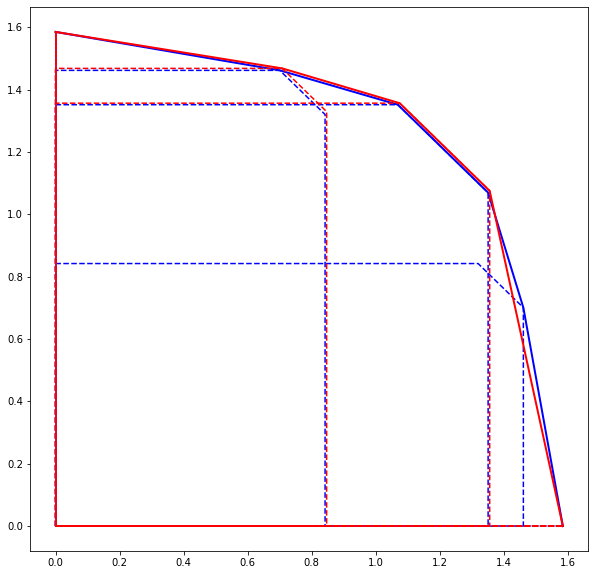

In [66]:
plt.figure(figsize=(10,10))

ea_unique_rate_tuples = np.unique(ea_opt_rate_tuples, axis=0)
for r_tuple in ea_unique_rate_tuples:
    
    print("EA: extremal rate tuple : ", r_tuple)
    tuple_id = ea_rate_tuples.index(tuple(r_tuple))
    priors = ea_priors_list[tuple_id]
    
    print("EA: prior_x1 : ", np.array(priors)[0].tolist())
    print("EA: prior_x2 : ", np.array(priors)[1].tolist())
    
    r1_vals, r2_vals = rate_region_vertices(r_tuple)  
    plt.plot(r1_vals, r2_vals,"b--")

plt.plot(ea_R1_vals, ea_R2_vals, "b-", linewidth=2, label="EA Inner Bound")

cl_unique_rate_tuples = np.unique(cl_opt_rate_tuples, axis=0)
for r_tuple in cl_unique_rate_tuples:
    
    print("CL: extremal rate tuple : ", r_tuple)
    tuple_id = cl_rate_tuples.index(tuple(r_tuple))
    priors = cl_priors_list[tuple_id]
    
    print("CL: prior_x1 : ", np.array(priors[0]).tolist())
    print("CL: prior_x2 : ", np.array(priors[1]).tolist())
    
    r1_vals, r2_vals = rate_region_vertices(r_tuple)  
    plt.plot(r1_vals, r2_vals,"r--")

plt.plot(cl_R1_vals, cl_R2_vals, "r-", linewidth=2, label="Classical Inner Bound")

In [38]:
cl_rate_tuples, cl_opt_dicts, cl_priors_list = scan_fp_rate_region(
    cl_ansatz,
    [np.array([0.25,0.25,0.5])],
    [np.array([0.25,0.25,0.5])],
    sample_width = 5,
    num_steps = 60,
    step_size = 0.5
)

cl_rate_tuples.extend(cl_rate_tuples)
cl_opt_dicts.extend(cl_opt_dicts)
cl_priors_list.extend(cl_priors_list)

prior_x1  =  [0.25, 0.25, 0.5]
prior_x2 =  [0.25, 0.25, 0.5]
iteration :  0 , score :  1.3365979307977423
elapsed time :  0.06137204170227051
iteration :  5 , score :  1.9066141639179714
elapsed time :  0.05013895034790039
iteration :  10 , score :  1.9527629044299801
elapsed time :  0.04809975624084473
iteration :  15 , score :  1.987983780642558
elapsed time :  0.04899096488952637
iteration :  20 , score :  2.0299813696248177
elapsed time :  0.04715585708618164
iteration :  25 , score :  2.08591750506273
elapsed time :  0.04815101623535156
iteration :  30 , score :  2.1955042383597982
elapsed time :  0.14395499229431152
iteration :  35 , score :  2.352519150941413
elapsed time :  0.048313140869140625
iteration :  40 , score :  2.427095557839545
elapsed time :  0.04928779602050781
iteration :  45 , score :  2.431332524696224
elapsed time :  0.04745888710021973
iteration :  50 , score :  2.431327931638236
elapsed time :  0.05053591728210449
iteration :  55 , score :  2.431311798994894


In [87]:
ea_mac_behavior = big_mac_game_behavior_fn(ea_ansatz)
cl_mac_behavior = big_mac_game_behavior_fn(cl_ansatz)

ea_behavior = np.around(ea_mac_behavior(ea_opt_dict["opt_settings"]), decimals=3)
print(ea_opt_dict["opt_settings"])

print(ea_behavior)
bisender_mac_mutual_info(ea_behavior, uniform3, uniform3)

[[array([], shape=(1, 0), dtype=float64)], [array([[-2.16877476],
       [ 0.97799877],
       [ 4.11441243]]), array([[ 4.10416236],
       [ 0.95739071],
       [-2.17902107]])]]
[[1.    0.    0.111 0.    0.    0.    0.111 0.    0.   ]
 [0.    1.    0.111 0.    0.    0.    0.111 0.    0.   ]
 [0.    0.    0.111 0.    0.    0.    0.111 0.    0.   ]
 [0.    0.    0.111 1.    0.    0.    0.111 0.    0.   ]
 [0.    0.    0.111 0.    1.    0.    0.111 0.    0.   ]
 [0.    0.    0.111 0.    0.    1.    0.111 0.    0.   ]
 [0.    0.    0.111 0.    0.    0.    0.111 0.    0.   ]
 [0.    0.    0.111 0.    0.    0.    0.111 1.    0.   ]
 [0.    0.    0.111 0.    0.    0.    0.111 0.    1.   ]]


(1.3535238163583418, 1.3535238163583418, 2.298091430632674)

In [85]:
test_behavior = np.array([
    [1,0.027,0.027,0.027,0,0.027,0.027,0.027,0],
    [0,0.777,0.027,0.027,0,0.027,0.027,0.027,0],
    [0,0.027,0.777,0.027,0,0.027,0.027,0.027,0],
    [0,0.027,0.027,0.777,0,0.027,0.027,0.027,0],
    [0,0.027,0.027,0.027,1,0.027,0.027,0.027,0],
    [0,0.027,0.027,0.027,0,0.777,0.027,0.027,0],
    [0,0.027,0.027,0.027,0,0.027,0.777,0.027,0],
    [0,0.027,0.027,0.027,0,0.027,0.027,0.777,0],
    [0,0.027,0.027,0.027,0,0.027,0.027,0.027,1],
])


print(bisender_mac_mutual_info(test_behavior, uniform3, uniform3))
bisender_mac_mutual_info(test_behavior, [0.4,0.4,.2], [0.4,0.4,0.2])

(1.2428505256678166, 1.2428505256678166, 2.2278962902055577)


(1.2039804413050001, 1.2039804413050001, 2.1623631560858536)

In [94]:
test_behavior2 = np.array([
    [1,0,0,0,0,0,0,0,1/9],
    [0,1,0,0,0,0,0,0,1/9],
    [0,0,1,0,0,0,0,0,1/9],
    [0,0,0,1,0,0,0,0,1/9],
    [0,0,0,0,1,0,0,0,1/9],
    [0,0,0,0,0,1,0,0,1/9],
    [0,0,0,0,0,0,1,0,1/9],
    [0,0,0,0,0,0,0,1,1/9],
    [0,0,0,0,0,0,0,0,1/9],
])

r_tuple = bisender_mac_mutual_info(test_behavior2, [0.4,0.4,0.2], [0.4,0.4,0.2])
bisender_mac_mutual_info(test_behavior2, uniform3, uniform3)

(1.469161119588, 1.469161119588, 2.7067194769096887)

In [98]:
ideal_behavior = np.eye(9)
r_tuple2 = bisender_mac_mutual_info(ideal_behavior, uniform3, uniform3)

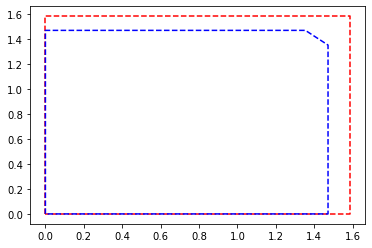

In [99]:
r1_vals, r2_vals = rate_region_vertices(r_tuple2)  
plt.plot(r1_vals, r2_vals,"r--")

r1_vals, r2_vals = rate_region_vertices(r_tuple)  
plt.plot(r1_vals, r2_vals,"b--")
